# Automatisierte Messung

In [315]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.constants as const
from scipy.signal import savgol_filter, find_peaks

Anode als Referenz:

In [316]:
label = [30,40,50,60,70]
anode = {}
for i in label:
    anode[i] = np.loadtxt('data/strom_an/' + str(i) + 'mu.txt', skiprows=3).T

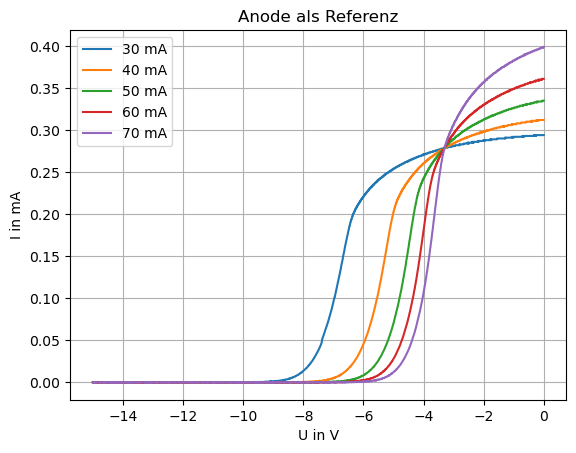

In [317]:
ax = plt.subplots()
for i in label:
    plt.plot(anode[i][0],anode[i][1]*1e3,label=str(i)+' mA')
plt.xlabel('U in V')
plt.ylabel('I in mA')
plt.title('Anode als Referenz')
plt.grid()
plt.legend()

plt.savefig('figures/Kennlinien_anode.pdf')

Erstes Glätten der Funktionen, um Ableitungen zu bestimmen.  
Nutzung eines Savitzky-Golay-Filters. Dabei wird ein  
kleines Fenster um die Daten gelegt und mit einem Polynom  
genähert. Anschließend wird das Fenster weiter geschoben.  
Die Ableitung wird über np.diff bestimmt und nutzt den  
Differenzenquotienten:

In [318]:
def plot_deriv(dict,i,w_0,w_1,w_2,lowerx=-10,upperx=-4,plot=True,label_dict='Anode',filter_polynom_order=3):
    '''Glätten, Ableiten und Plotten der automatisierten Messkurven.
    Übergebe dict und windowsize w_0, w_1, w_2 für entsprechende Savgol-Filter.
    Rückgabe der einzelnen Kurven'''
    Ismooth = savgol_filter(dict[i][1], w_0, filter_polynom_order) # window size 51, polynomial order 3
    U = dict[i][0]
    I_deriv = np.diff(Ismooth)/np.diff(U)
    # Für x-Achse werden Mittelpunkte der jeweiligen Daten genommen (Ableitung hat n-1 Einträge)
    # Die Spannungswerte haben stets den gleichen Abstand (Anode: 0.006, Kathode: 0.005):
    if label_dict=='Anode':
        U_deriv = U[:-1] + 0.5*np.diff(U)  # 0.003
    if label_dict=='Kathode':
        U_deriv = U[:-1] + 0.5*np.diff(U)  # 0.0025
    I_derivsmooth = savgol_filter(I_deriv, w_1, filter_polynom_order)

    I_deriv2 = np.diff(I_derivsmooth)/np.diff(U_deriv)
    if label_dict=='Anode':
        U_deriv2 = U_deriv[:-1] + 0.5*np.diff(U_deriv)
    if label_dict=='Kathode':
        U_deriv2 = U_deriv[:-1] + 0.5*np.diff(U_deriv) 
    I_derivsmooth2 = savgol_filter(I_deriv2, w_2, filter_polynom_order)

    if plot==True:
        ax = plt.subplots(figsize=(8,6))
        plt.plot(dict[i][0],dict[i][1],label='I in A')
        plt.plot(dict[i][0],Ismooth,linestyle='dotted',label='I in A (geglättet)')
        plt.plot(U_deriv,I_deriv,label=r'1. Ableitung von I in $\frac{\mathrm{A}}{\mathrm{V}}$')
        plt.plot(U_deriv,I_derivsmooth,linestyle='dotted',label=r'1. Ableitung von I in $\frac{\mathrm{A}}{\mathrm{V}}$ (geglättet)')
        plt.plot(U_deriv2, I_deriv2,label=r'2. Ableitung von I in $\frac{\mathrm{A}}{\mathrm{V}^\mathrm{2}}$')
        plt.plot(U_deriv2, I_derivsmooth2,linestyle='dotted',label=r'2. Ableitung von I in $\frac{\mathrm{A}}{\mathrm{V}^\mathrm{2}}$ (geglätted)')
        plt.grid()
        plt.legend()
        plt.xlabel('U in V')
        if label_dict=='Anode':
            plt.title('Entladungsstrom von '+str(i)+' mA (Anode als Referenz)')
        else:
            plt.title('Entladungsstrom von '+str(i)+' mA ('+label_dict+' als Referenz)')
        plt.xlim(lowerx,upperx)
    return Ismooth, U, I_deriv, U_deriv, I_derivsmooth, I_deriv2, U_deriv2, I_derivsmooth2

def floating_potential(I,U):
    '''Bestimmung als Nullstelle des gemessenen Stroms '''
    sign = np.sign(I)
    nst = []
    for i in range(len(sign)-1):
        if sign[i] != sign[i+1]:
            nst.append(i)
    if len(nst) != 1:
        print('Probleme bei Bestimmung des Floating Potentials')
    else:
        # Lineare Interpolation der Nullstelle
        j = nst[0]
        slope, intercept, r, p, se = linregress(U[j:j+2], I[j:j+2])
        float_pot = -intercept/slope
        return float_pot, j

def plasma_potential(dI,U,height=1e-4):
    '''Bestimmung als Maximmum der ersten Ableitung des Stroms'''
    ayuda_plasma_pot = find_peaks(dI,height)
    plasma_pot = U[ayuda_plasma_pot[0][0]]
    return plasma_pot, ayuda_plasma_pot[0][0]

def satt(I,U,dI,dU,height=1e-4,index_err_pot=17):
    '''Ionensättigungsstrom wird unterhalb der Plasmapotentials als konstant angenommen.
    Mittelung über die ersten 200 Werte der Kurve. Elektronensättigungsstrom als
    Strom am Plasmapotential von dem noch der Ionensätttigungsstrom abgezogen wird. 
    ion_satt wird addiert, da dieser selbst negativ ist.'''
    ion_satt = np.mean(I[:200])
    ion_satt_std = np.std(I[:200])
    ayuda_plasma_pot = find_peaks(dI,height)
    e_satt = I[ayuda_plasma_pot[0][0]] + ion_satt
    ayuda_err = 0.5*abs(I[ayuda_plasma_pot[0][0]+index_err_pot]-I[ayuda_plasma_pot[0][0]-index_err_pot])
    e_satt_err = ayuda_err + ion_satt_std
    return ion_satt, e_satt, ion_satt_std, e_satt_err


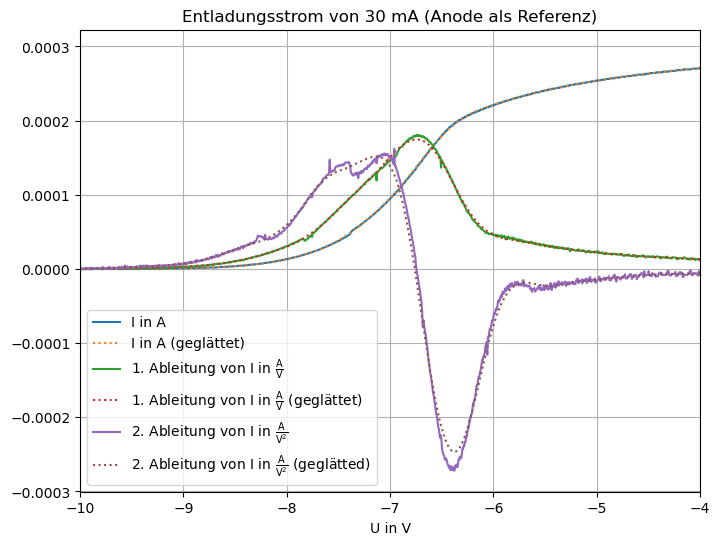

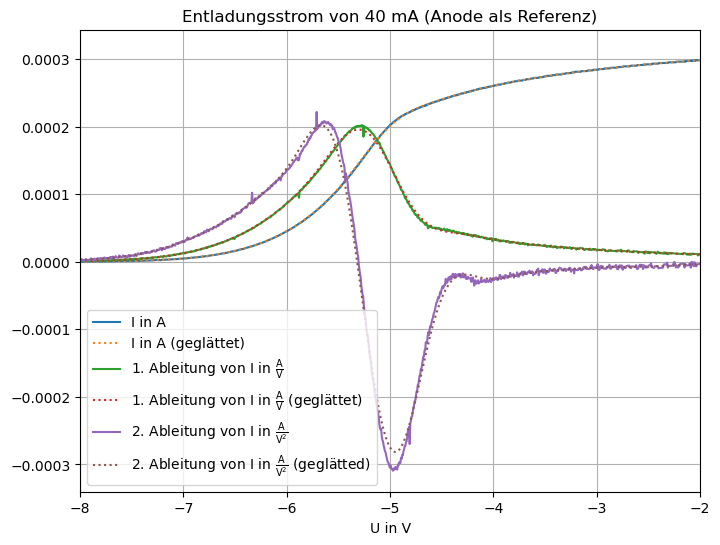

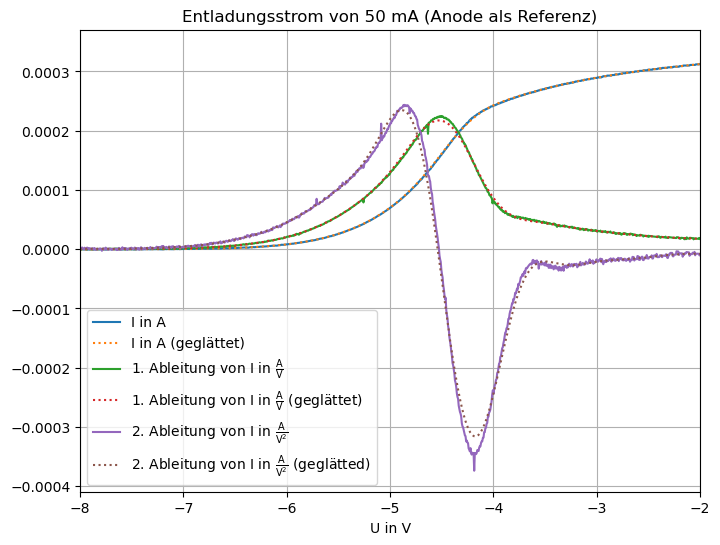

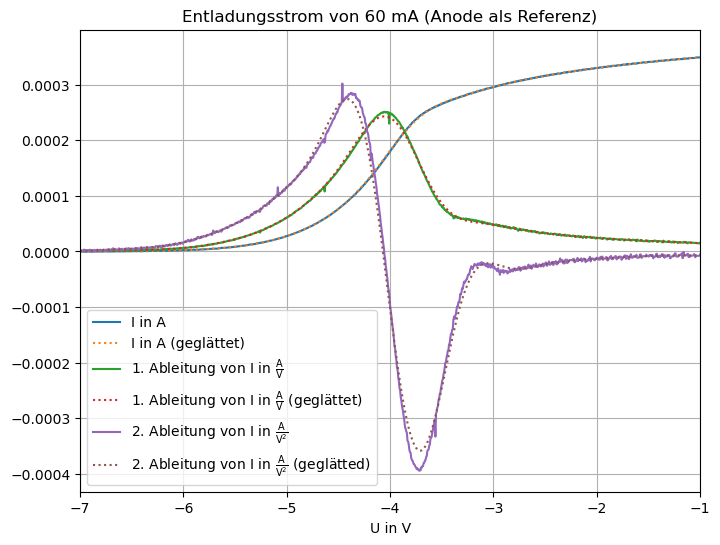

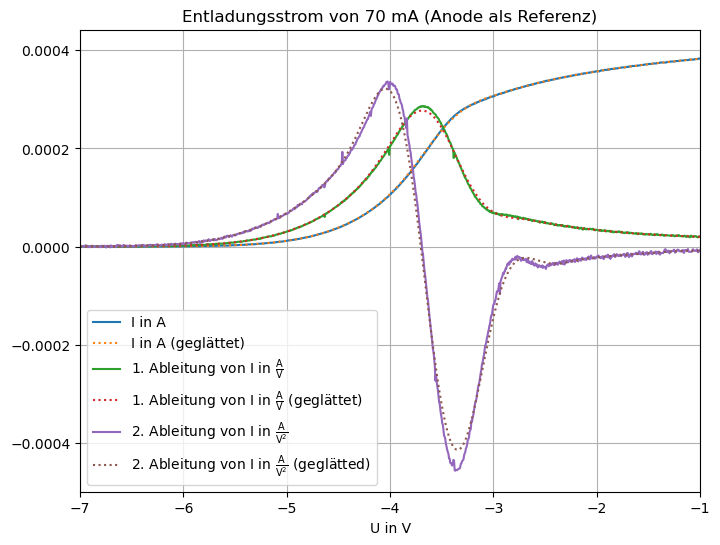

In [319]:
I_30 = plot_deriv(anode,30,150,150,150,lowerx=-10,upperx=-4)
plt.savefig('figures/deriv_anode.pdf')
I_40 = plot_deriv(anode,40,150,150,150,lowerx=-8,upperx=-2)
I_50 = plot_deriv(anode,50,150,150,150,lowerx=-8,upperx=-2)
I_60 = plot_deriv(anode,60,150,150,150,lowerx=-7,upperx=-1)
I_70 = plot_deriv(anode,70,150,150,150,lowerx=-7,upperx=-1)

Fehler für Potentiale durch unterschiedliche Glättungen abgeschätzt. --> Potentiale relativ gut.  
Fehler jeweils auf 0.1 V bzw. 17 Indizes geschätzt.
Standardabweichung für Ionensättigungsstrom.  
Elektronensättigungsstrom.

Floating Potential:  [-9.53670234434316, -8.133360496463014, -7.288323451943465, -6.8071811163889855, -6.346471130250295]
Plasma Potential:  [-6.747, -5.306, -4.525, -4.057, -3.6905]
Ionensättigungsstrom:  [-2.7690701813219955e-07, -3.3081198547781503e-07, -3.6497593102162077e-07, -4.1291147259769715e-07, -4.3539372935764766e-07]
Fehler Ionensättigungsstrom:  [2.316910025676508e-08, 9.076308397678822e-09, 7.61077270897661e-09, 3.4637693265993155e-08, 2.3014614537957647e-08]
Elektronensättigungsstrom:  [0.00013647883234457577, 0.00014436077733763375, 0.00015507131528128153, 0.00016612791353129742, 0.0001837144385991503]
Fehler Elektronensättigungsstrom:  [1.809176535327459e-05, 2.0213575185989232e-05, 2.249284168765883e-05, 2.520253294717442e-05, 2.87091884458743e-05]


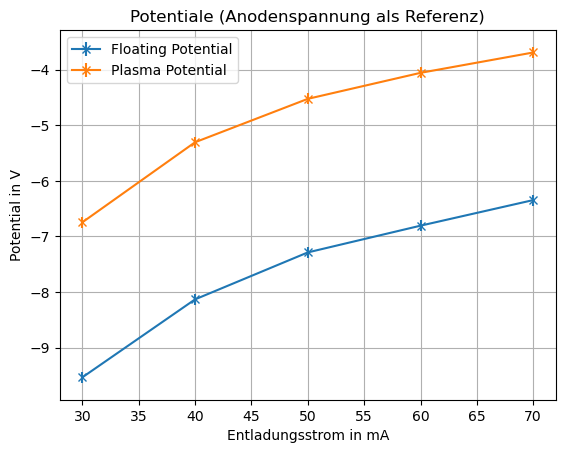

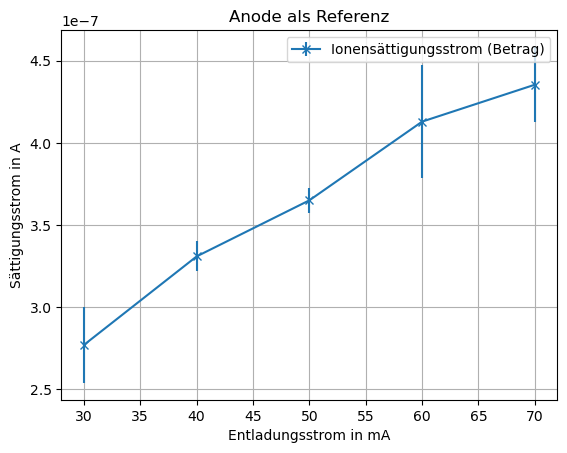

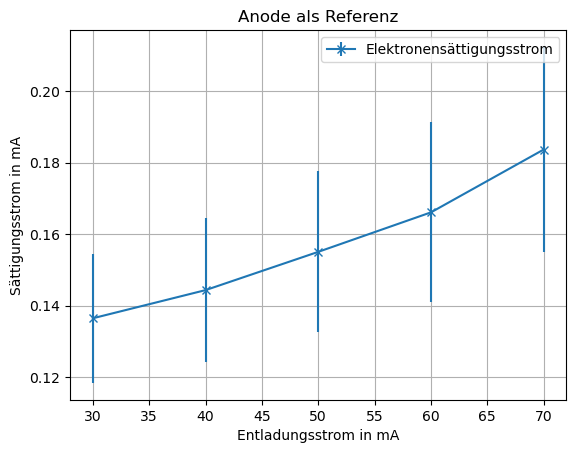

In [320]:
currents = [I_30,I_40,I_50,I_60,I_70]
labels = [30,40,50,60,70]
float_pot = []
plasma_pot = []
float_pot_index = []
plasma_pot_index = []
i_satt = []
i_satt_std = []
e_satt = []
e_satt_err = []
for current in currents:
    float_pot.append(floating_potential(current[0],current[1])[0])
    plasma_pot.append(plasma_potential(current[4],current[3])[0])
    float_pot_index.append(floating_potential(current[0],current[1])[1])
    plasma_pot_index.append(plasma_potential(current[4],current[3])[1])
    ayuda = satt(current[0],current[1],current[4],current[3])
    i_satt.append(ayuda[0])
    e_satt.append(ayuda[1])
    i_satt_std.append(ayuda[2])
    e_satt_err.append(ayuda[3])

ax = plt.subplots()
plt.errorbar(labels,float_pot,yerr=0.1,marker='x',label='Floating Potential')
plt.errorbar(labels,plasma_pot,yerr=0.1,marker='x',label='Plasma Potential')
plt.grid()
plt.legend()
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Potential in V')
plt.title('Potentiale (Anodenspannung als Referenz)')
plt.savefig('figures/pot_anode.pdf')

ax = plt.subplots()
plt.errorbar(labels,-1.0*np.array(i_satt),yerr=i_satt_std,marker='x',label='Ionensättigungsstrom (Betrag)')
plt.grid()
plt.legend()
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Sättigungsstrom in A')
plt.title('Anode als Referenz')
plt.savefig('figures/ion_satt_anode.pdf')

ax = plt.subplots()
plt.errorbar(labels,np.array(e_satt)*1e3,yerr=np.array(e_satt_err)*1e3,marker='x',label='Elektronensättigungsstrom')
plt.grid()
plt.legend()
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Sättigungsstrom in mA')
plt.title('Anode als Referenz')
plt.savefig('figures/e_satt_anode.pdf')

print('Floating Potential: ',float_pot)
print('Plasma Potential: ',plasma_pot)
print('Ionensättigungsstrom: ',i_satt)
print('Fehler Ionensättigungsstrom: ',i_satt_std)
print('Elektronensättigungsstrom: ',e_satt)
print('Fehler Elektronensättigungsstrom: ',e_satt_err)

Bestimmung der Elektronentemperatur über Elektronenstrom unterhalb des Plasmapotentials.  
Hier kann der Ionenstrom als konstant angenommen und abgezogen werden.  
Die Steigung des logarithmierten Stromes ist e/(k_b*T_e). Anschließend können  
die Elektronendichte und Ionendichte sowie die entsprechenden Debye-Längen und Plasmaparameter.

In [321]:
def slope_to_T(slope):
    return const.e/const.k/slope
def T_err(slope,slope_err):
    return const.e*slope_err/const.k/slope/slope
def n_e(I_esatt,A,T_e):
    '''Elektronendichte über Elektronensättigungsstrom, Sondenfläche
    und die Elektronentemperatur'''
    return I_esatt/A/const.e*np.sqrt(2*np.pi*const.m_e/const.k/T_e)
def n_e_err(I_esatt,I_esatt_err,A,A_err,T_e,T_e_err):
    return 1.0/A/const.e*np.sqrt(2*np.pi*const.m_e/const.k/T_e)*(I_esatt_err+I_esatt*A_err/A+0.5*I_esatt*T_e_err/T_e)
def n_i(I_isatt,A,T_e,m_i):
    '''Ionendichte eigentlich gleich der Elektronendichte im Plasma. Im 
    Raum um Sonde entsteht aber Randschicht. An der Kante nur 0.61-fache
    der Ionendichte im Plasma. Nutze Korrekturfaktor. Zudem haben Ionen
    die Bohm-Geschwindigkeit. Nutzung des Betrags des Ionenstroms.'''
    return -1.0*I_isatt/0.6/A/const.e*np.sqrt(m_i/const.k/T_e)
def n_i_err(I_isatt,I_isatt_err,A,A_err,T_e,T_e_err,m_i):
    return -1.0/0.6/A/const.e*np.sqrt(m_i/const.k/T_e)*(I_isatt_err+I_isatt*A_err/A+0.5*I_isatt*T_e_err/T_e)
def debye(T,n):
    '''Berechnung der Debye-Länge aus Temperatur und Dichte'''
    return np.sqrt(const.epsilon_0*const.k*T/const.e/const.e/n)
def debye_err(T,T_err,n,n_err):
    return 0.5*np.sqrt(const.epsilon_0*const.k*T/const.e/const.e/n)*(n_err/n+T_err/T)
def plasma_parameter(lambda_D,n):
    '''Zahl der Teilchen in Debye-Kugel aus Debye-Länge und Dichte'''
    return n*4/3*np.pi*lambda_D**3
def plasma_parameter_err(lambda_D,lambda_D_err,n,n_err):
    return 4.0*np.pi*(n_err/3*lambda_D**3+n*lambda_D**2*lambda_D_err)

C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1217133701.py:32: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1217133701.py:32: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1217133701.py:32: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1217133701.py:32: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1217133701.py:32: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])


Elektronentemperatur:  [4820.0688714866665, 4899.764611856464, 4896.2349643659545, 4829.286862072634, 4699.893948730053]
Fehler Elektronentemperatur:  [11.15451034304298, 6.099233149347733, 8.938944060129028, 5.254922544185517, 7.871630212416556]
Elektronendichte:  [858683753304241.5, 900857654688698.5, 968043592308329.4, 1044228827655707.0, 1170560406774150.5]
Fehler Elektronendichte:  [198823190877637.22, 214827280354130.97, 235996730378126.25, 261136300962229.28, 298415925283717.1]
Ionendichte:  [312599007675188.56, 370402476278313.9, 408802321663586.2, 465688702261391.7, 497758167251653.8]
Fehler Ionendichte:  [4786556594328.003, 26303032441169.508, 31840026004315.766, 6744880177124.871, 22799413524583.895]
Elektronen-Debye-Länge:  [0.00016349919225582094, 0.00016094042147419814, 0.00015519912938775324, 0.000148405253484058, 0.0001382778844509508]
Fehler Elektronen-Debye-Länge:  [1.9117823238358048e-05, 1.9289878728402686e-05, 1.9059459843907647e-05, 1.8637019662730125e-05, 1.77416

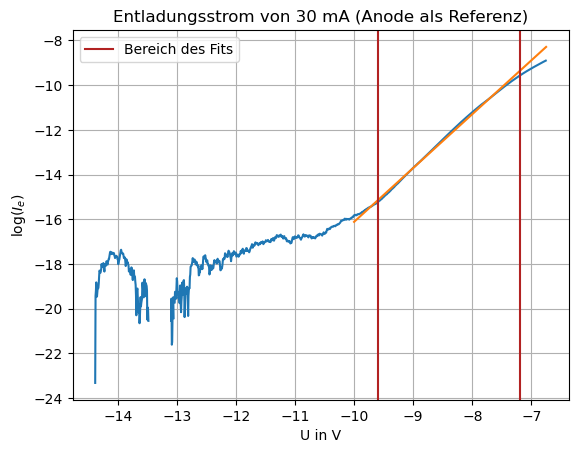

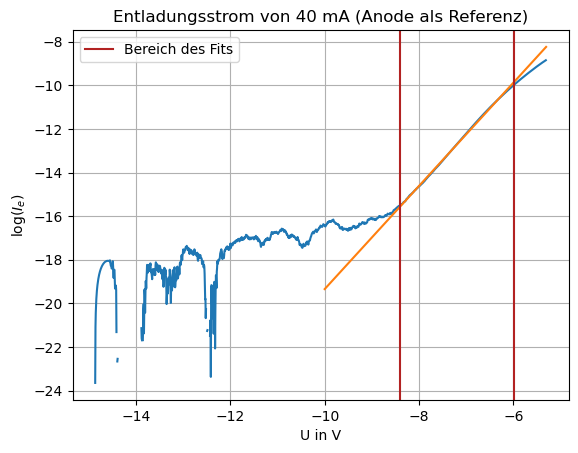

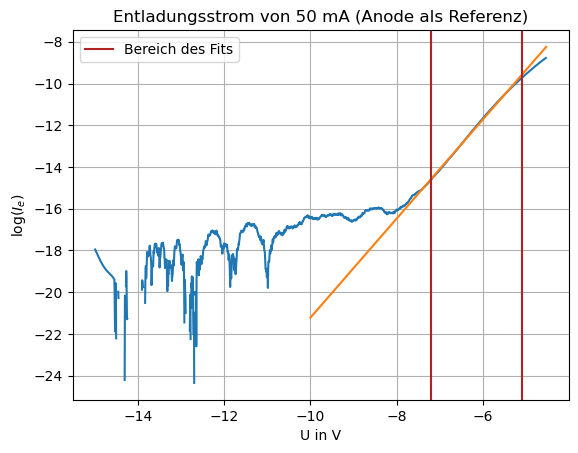

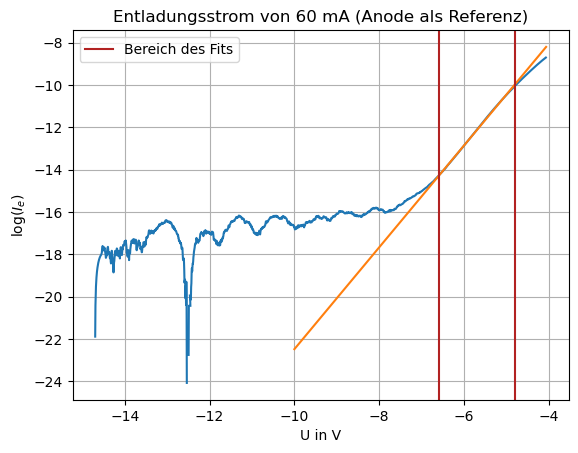

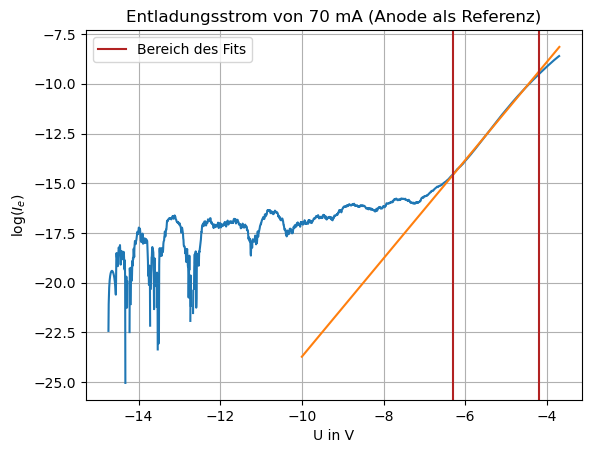

In [322]:
currents = [I_30,I_40,I_50,I_60,I_70]
labels = [30,40,50,60,70]
fit_lim = [(900,1300),(1100,1500),(1300,1650),(1400,1700),(1450,1800)]  # Grenzen für die einzelnen Fits
def lin_func(m,b,x):
    return m*x+b

T_ion = 300.0
T_ion_err = 10.0

T_el = []
n_el = []
n_ion = []
debye_e = []
debye_i = []
parameter_e = []
parameter_i = []
T_el_err = []
n_el_err = []
n_ion_err = []
debye_e_err = []
debye_i_err = []
parameter_e_err = []
parameter_i_err = []

A = 9.2e-6  # Sondenfläche
A_err = 0.9e-6  # Fehler Sondenfläche
m_i = 6.6335e-26  # Masse Argon in kg

for i,current in enumerate(currents):
    '''Betrachte bis zum Plasmapotential.'''
    U = current[1][:plasma_pot_index[i]]
    I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
    ax = plt.subplots()
    plt.plot(U,I)
    plt.xlabel('U in V')
    plt.ylabel('$\log(I_e)$')
    plt.grid()
    plt.title('Entladungsstrom von '+str(labels[i])+' mA (Anode als Referenz)')
    
    m, b, r, p, se = linregress(U[fit_lim[i][0]:fit_lim[i][1]],I[fit_lim[i][0]:fit_lim[i][1]])
    lin = np.linspace(-10.0,current[1][plasma_pot_index[i]],1000)
    plt.plot(lin,lin_func(m,b,lin))
    plt.axvline(U[fit_lim[i][0]],color='firebrick')
    plt.axvline(U[fit_lim[i][1]],color='firebrick',label='Bereich des Fits')

    plt.legend()
    plt.savefig('figures/bestimmung_T_'+str(labels[i])+'anode.pdf')

    T_el.append(slope_to_T(m))
    T_el_err.append(T_err(m,se))
    n_el.append(n_e(e_satt[i],A,T_el[-1]))
    n_el_err.append(n_e_err(e_satt[i],e_satt_err[i],A,A_err,T_el[-1],T_el_err[-1]))
    n_ion.append(n_i(i_satt[i],A,T_el[-1],m_i))
    n_ion_err.append(n_i_err(i_satt[i],i_satt_std[i],A,A_err,T_el[-1],T_el_err[-1],m_i))    
    debye_e.append(debye(T_el[-1],n_el[-1]))
    debye_e_err.append(debye_err(T_el[-1],T_el_err[-1],n_el[-1],n_el_err[-1]))
    #debye_i.append(debye(T_el[-1],n_ion[-1]))
    #debye_i_err.append(debye_err(T_el[-1],T_el_err[-1],n_ion[-1],n_ion_err[-1]))
    debye_i.append(debye(T_ion,n_ion[-1]))
    debye_i_err.append(debye_err(T_ion,T_ion_err,n_ion[-1],n_ion_err[-1]))
    parameter_e.append(plasma_parameter(debye_e[-1],n_el[-1]))
    parameter_e_err.append(plasma_parameter_err(debye_e[-1],debye_e_err[-1],n_el[-1],n_el_err[-1]))
    parameter_i.append(plasma_parameter(debye_i[-1],n_ion[-1]))
    parameter_i_err.append(plasma_parameter_err(debye_i[-1],debye_i_err[-1],n_ion[-1],n_ion_err[-1]))

print('Elektronentemperatur: ',T_el)
print('Fehler Elektronentemperatur: ',T_el_err)
print('Elektronendichte: ',n_el)
print('Fehler Elektronendichte: ',n_el_err)
print('Ionendichte: ',n_ion)
print('Fehler Ionendichte: ',n_ion_err)
print('Elektronen-Debye-Länge: ',debye_e)
print('Fehler Elektronen-Debye-Länge: ',debye_e_err)
print('Ionen-Debye-Länge: ',debye_i)
print('Fehler Ionen-Debye-Länge: ',debye_i_err)
print('Elektronen-Plasmaparameter: ',parameter_e)
print('Fehler Elektronen-Plasmaparameter: ',parameter_e_err)
print('Ionen-Plasmaparameter: ',parameter_i)
print('Fehler Ionen-Plasmaparameter: ',parameter_i_err)

# Wie muss ich Sondenfläche für logarithmierten Strom einbeziehen???  --> eigentlich nicht würde ich sagen...
# Debye-Länge und Plasmaparameter für Ionen mit Elektronentemperatur im GG möglich???

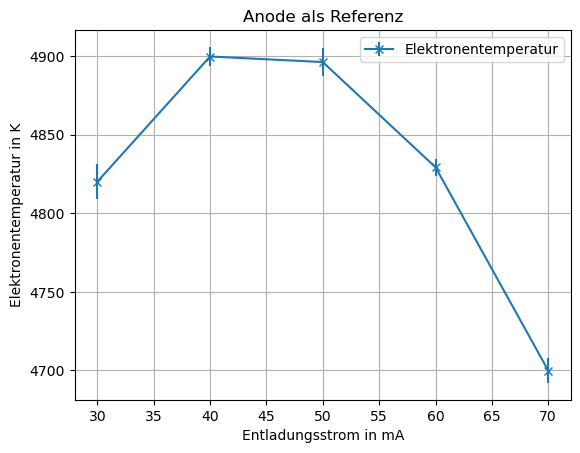

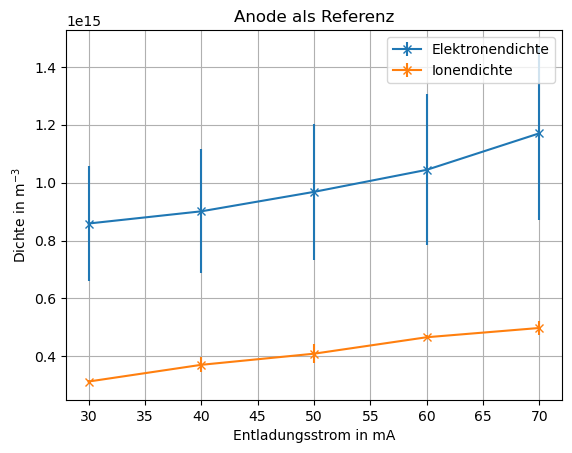

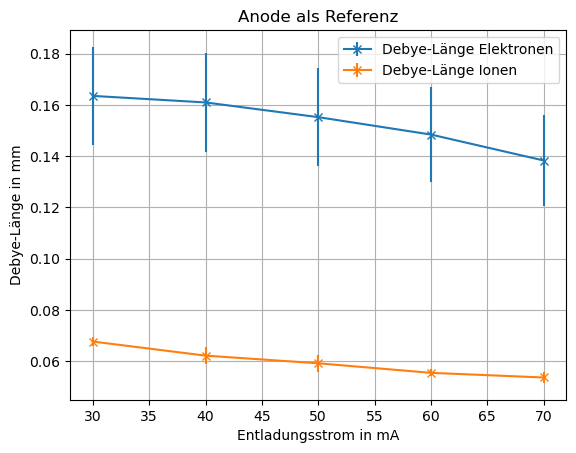

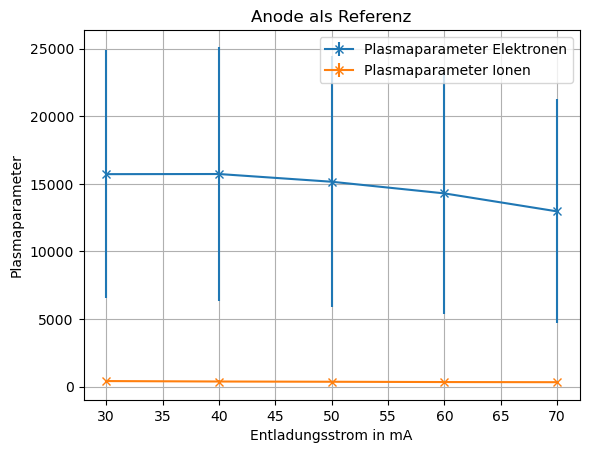

In [323]:
labels = [30,40,50,60,70]

ax = plt.subplots()
plt.errorbar(labels,T_el,yerr=T_el_err,marker='x',label='Elektronentemperatur')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Elektronentemperatur in K')
plt.title('Anode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/Te_anode.pdf')

ax = plt.subplots()
plt.errorbar(labels,n_el,yerr=n_el_err,marker='x',label='Elektronendichte')
plt.errorbar(labels,n_ion,yerr=n_ion_err,marker='x',label='Ionendichte')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Dichte in m$^{-3}$')
plt.title('Anode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/n_anode.pdf')

ax = plt.subplots()
plt.errorbar(labels,np.array(debye_e)*1e3,yerr=np.array(debye_e_err)*1e3,marker='x',label='Debye-Länge Elektronen')
plt.errorbar(labels,np.array(debye_i)*1e3,yerr=np.array(debye_i_err)*1e3,marker='x',label='Debye-Länge Ionen')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Debye-Länge in mm')
plt.title('Anode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/debye_anode.pdf')

ax = plt.subplots()
plt.errorbar(labels,parameter_e,yerr=parameter_e_err,marker='x',label='Plasmaparameter Elektronen')
plt.errorbar(labels,parameter_i,yerr=parameter_i_err,marker='x',label='Plasmaparameter Ionen')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Plasmaparameter')
plt.title('Anode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/eta_anode.pdf')

Anwendung der Druyvestein-Methode. $U_p=\phi_p-\phi_s$ Wie groß ist die Sonden-Fläche A???  
Der Ionensättigungsstrom wird nicht abgezogen. Im Bereich bis zum Plasmapotential nehmen  
wir diesen als konstant an, weshalb keine Auswirkungen auf die Abeitungen bestehen:

In [324]:
def druyvestein(A,d2I):
    '''Beim Plotten noch bedenken, dass U_p transformiert wird auf Geschwindigkeit.
    Minus weglassen durch Trafo auf Geschwindigkeit???'''
    # return const.m_e**2/(const.e**3*2*const.pi*A)*d2I
    # Korrrekturfaktor, um Strom auf Geschwindigkeit zu transformieren???
    return const.m_e**2/(const.e**3*2*const.pi*A)*d2I*(const.e/const.m_e)
def druyvestein_2(A,d2I,v):
    '''Beim Plotten noch bedenken, dass U_p transformiert wird auf Geschwindigkeit.
    Minus weglassen durch Trafo auf Geschwindigkeit???'''
    # return const.m_e**2/(const.e**3*2*const.pi*A)*d2I
    # Korrrekturfaktor, um Strom auf Geschwindigkeit zu transformieren???
    return 4*np.pi*v**2*const.m_e**2/(const.e**3*2*const.pi*A)*d2I#*(const.e/const.m_e)
def U_p_to_v(U_p):
    '''Wie gehe ich am besten mit den Minuszeichen um???'''
    return np.sqrt(2*const.e*U_p/const.m_e)
def maxwell(v,T):
    '''Maxwell-Verteilung für Temperatur T'''
    return 4*const.pi*v**2*(const.m_e/(2*const.pi*const.k*T))**(3/2)*np.exp(-const.m_e*v**2/2/const.k/T)
def maxwell_2(v,T,n):
    '''Maxwell-Verteilung für Temperatur T und Dichte n'''
    return n*4*const.pi*v**2*(const.m_e/(2*const.pi*const.k*T))**(3/2)*np.exp(-const.m_e*v**2/2/const.k/T)

C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)


5727771399495.137
Druyvestein:  -662130599605918.6
Maxwell:  -780045977046000.5


C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)


3705195276756.482
Druyvestein:  -722761169451183.1
Maxwell:  -820156802465273.0
3742734600820.0356
Druyvestein:  -793228854579934.0
Maxwell:  -895251802713453.5


C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)


4548428826782.74
Druyvestein:  -856019249480726.9
Maxwell:  -977320092580095.9
5032033958221.989
Druyvestein:  -963670930867569.8
Maxwell:  -1099777560275510.5


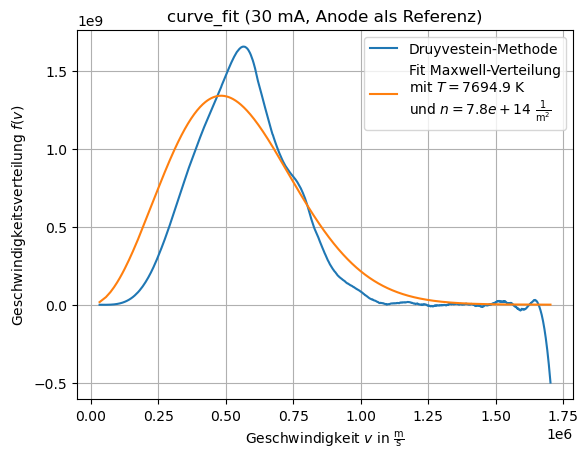

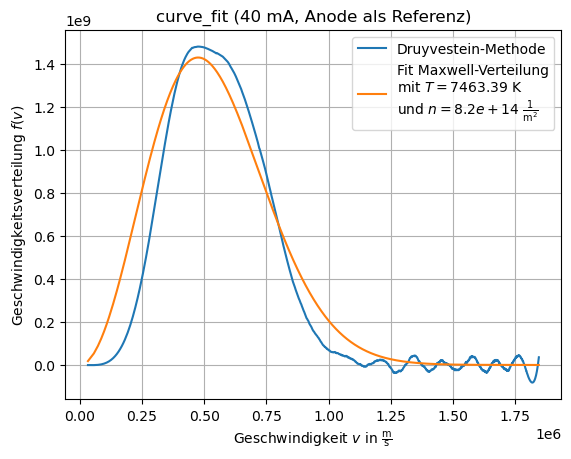

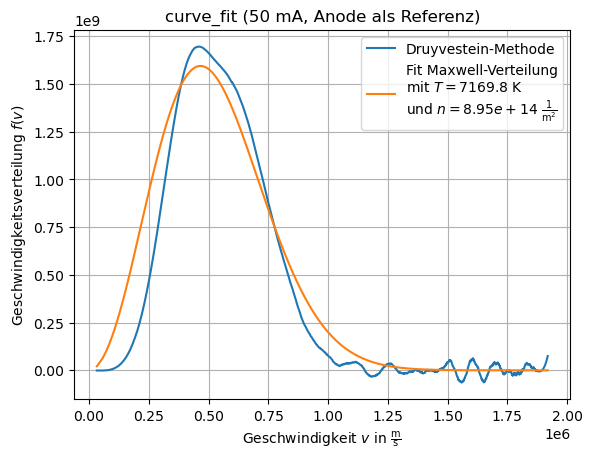

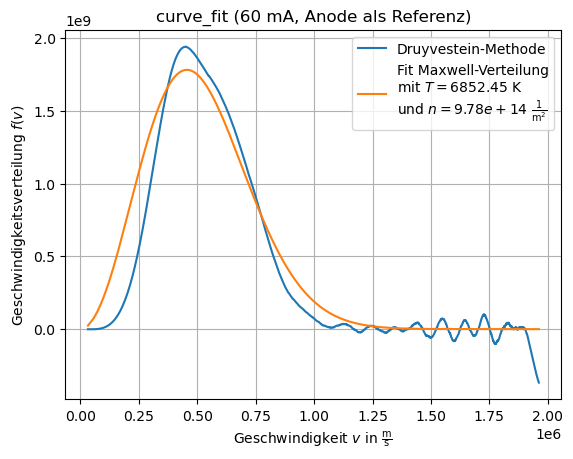

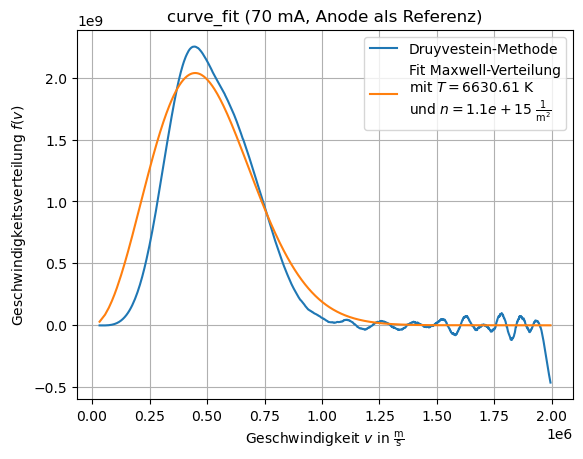

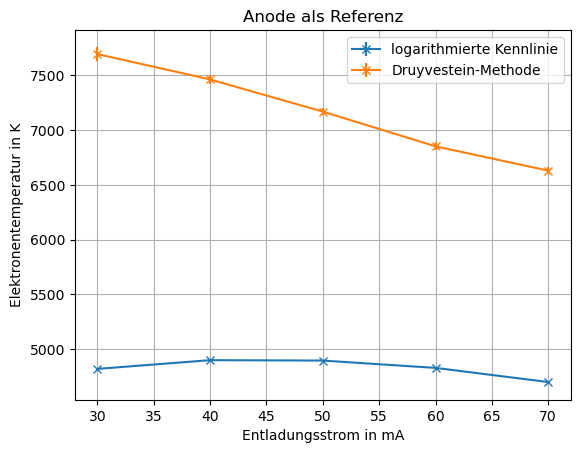

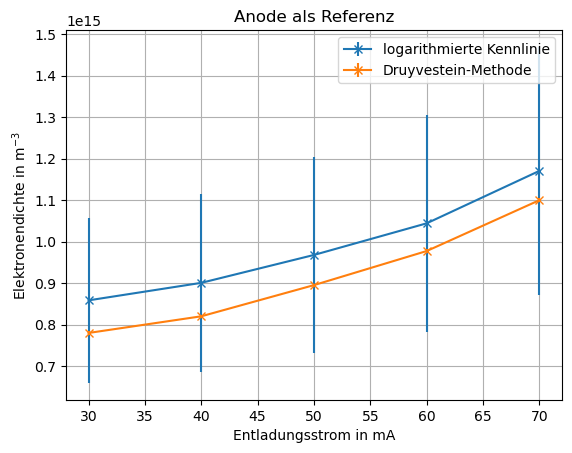

In [325]:
from scipy.optimize import curve_fit

currents = [I_30,I_40,I_50,I_60,I_70]
labels = [30,40,50,60,70]
hand_fit = [4900,4000,4800,4800,4800]
T_list = []
T_error_list = []
n_list = []
n_error_list = []

for i, current in enumerate(currents):
    I_1 = current[4]
    U_1 = current[3]
    I_2 = current[7]
    U_2 = current[6]
    phi_p = plasma_pot[i]
    # print(phi_p)

    # Berechnung der Geschwindigkeitsverteilung
    #f = druyvestein(9.2e-6,I_2)
    U_p = phi_p - U_2
    v = U_p_to_v(U_p)
    f = druyvestein_2(9.2e-6,I_2,v)

    # Normierung Druyvestein (nan-Werte müssen entfernt werden; Druyvestein muss umgedreht werden, da v falsch herum ist)
    # Fitte Temperatur über scipy.optimize.curve_fit mit p0 als inital guess
    mask = np.isfinite(v) & np.isfinite(f)
    # f_norm = -1.0*f[mask]/np.trapz(f[mask],v[mask])
    f = f[mask]
    # f = -1.0*f[mask]/np.trapz(f[mask],v[mask])
    v = v[mask]

    # popt, pconv = curve_fit(maxwell,v,f_norm,p0=4800)
    # T = popt[0]
    # T_std = np.sqrt(np.diag(pconv)[0])    # Standardabweichung der Temperatur
    # T_list.append(T)
    # T_error_list.append(T_std)

    # maxwell1 = maxwell(v,T)
    # maxwell2 = maxwell(v,hand_fit[i])

    popt, pconv = curve_fit(maxwell_2,v,f,p0=(7500,1.0e15))
    T = popt[0]
    T_std = np.sqrt(np.diag(pconv)[0])    # Standardabweichung der Temperatur
    T_list.append(T)
    T_error_list.append(T_std)
    n = popt[1]
    n_std = np.sqrt(np.diag(pconv)[1])
    n_list.append(n)
    n_error_list.append(n_std)
    print(n_std)

    maxwell1 = maxwell_2(v,T,n)

    print('Druyvestein: ',np.trapz(f,v))
    print('Maxwell: ',np.trapz(maxwell1,v))



    ax = plt.subplots()
    # plt.plot(v,f_norm,label='Druyvestein-Methode')
    plt.plot(v,f,label='Druyvestein-Methode')
    plt.plot(v,maxwell1,label='Fit Maxwell-Verteilung\nmit $T='+str(round(T,2))+'$ K\nund '+r'$n=%.3g$ $\frac{1}{\mathrm{m}^2}$' % n)
    plt.grid()
    plt.title('curve_fit ('+str(labels[i])+' mA, Anode als Referenz)')
    plt.xlabel(r'Geschwindigkeit $v$ in $\frac{\mathrm{m}}{\mathrm{s}}$')
    plt.ylabel('Geschwindigkeitsverteilung $f(v)$')
    plt.legend()
    plt.savefig('figures/druyvestein_fit_+'+str(labels[i])+'_anode.pdf')

    # ax = plt.subplots()
    # plt.plot(v,f_norm,label='Druyvestein-Methode')
    # plt.plot(v,maxwell2,label='Fit Maxwell-Verteilung\nmit $T='+str(hand_fit[i])+'$ K')
    # plt.grid()
    # plt.title('händischer Fit ('+str(labels[i])+' mA, Anode als Referenz)')
    # plt.xlabel(r'Geschwindigkeit $v$ in $\frac{\mathrm{m}}{\mathrm{s}}$')
    # plt.ylabel('normierte Wahrscheinlichkeitsdichte')
    # plt.legend()
    # plt.savefig('figures/druyvestein_hand_+'+str(labels[i])+'_anode.pdf')

ax = plt.subplots()
plt.errorbar(labels,T_el,yerr=T_el_err,marker='x',label='logarithmierte Kennlinie')
plt.errorbar(labels,T_list,yerr=T_error_list,marker='x',label='Druyvestein-Methode')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Elektronentemperatur in K')
plt.title('Anode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/comparison_T_anode.pdf')

ax = plt.subplots()
plt.errorbar(labels,n_el,yerr=n_el_err,marker='x',label='logarithmierte Kennlinie')
plt.errorbar(labels,n_list,yerr=n_error_list,marker='x',label='Druyvestein-Methode')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Elektronendichte in m$^{-3}$')
plt.title('Anode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/comparison_n_anode.pdf')

Kathode als Referenz:

In [326]:
label = [30,40,50,60,70]
kathode = {}
for i in label:
    kathode[i] = np.loadtxt('data/strom_kat/' + str(i) + 'mu_kat.txt', skiprows=3).T

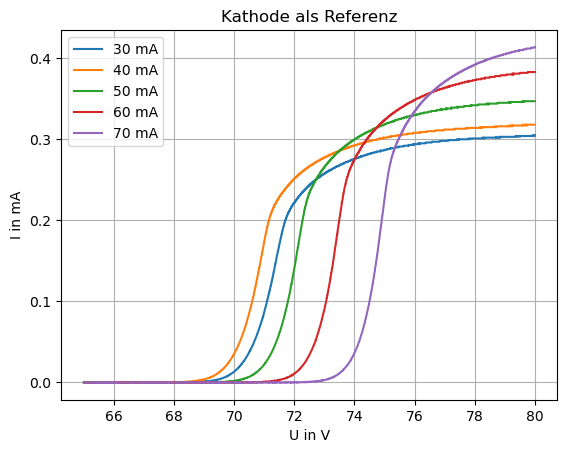

In [327]:
ax = plt.subplots()
for i in label:
    plt.plot(kathode[i][0],kathode[i][1]*1e3,label=str(i)+' mA')
plt.xlabel('U in V')
plt.ylabel('I in mA')
plt.title('Kathode als Referenz')
plt.grid()
plt.legend()
#plt.xlim(72.2,72.3)
plt.savefig('figures/Kennlinien_kathode.pdf')

Glätten und Ableiten der aufgenommenen Kurven:

[1.64296545e-04 1.65628865e-04 1.66924752e-04 8.44688838e-05
 1.67765028e-04 1.71296938e-04 1.71851161e-04 1.71150272e-04
 8.66966538e-05 1.73954353e-04 1.77994289e-04 1.78328179e-04
 1.76788837e-04 8.95659443e-05 1.80370999e-04 1.83457786e-04
 1.83859589e-04 1.83684721e-04 9.23830328e-05 1.85790795e-04
 1.88984644e-04 1.89158971e-04 1.88529904e-04 9.48712590e-05
 1.92551026e-04 1.92830904e-04 1.94407283e-04 1.94686161e-04
 9.79749697e-05 1.97010688e-04 1.96962570e-04 2.00058563e-04
 2.00157027e-04 1.00533991e-04 2.02954337e-04 2.02496935e-04
 2.05229659e-04 1.02309589e-04 2.06012351e-04 2.07604367e-04
 2.08049559e-04 2.08150132e-04 1.04850047e-04 2.10127875e-04
 2.12108682e-04 2.11986305e-04 2.13163485e-04 1.05478497e-04
 2.12357015e-04 2.12813829e-04 2.13942647e-04 2.15577964e-04
 1.07311346e-04 2.14278378e-04 2.15974070e-04 2.14573926e-04
 2.15575226e-04 1.06998467e-04 2.16001314e-04 2.16953946e-04
 2.14867785e-04 2.16384879e-04 1.06870509e-04 2.15201273e-04
 2.16235719e-04 2.136193

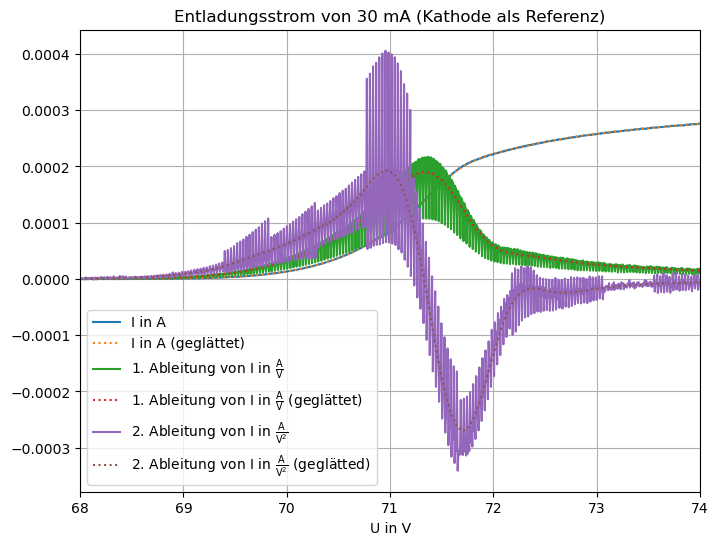

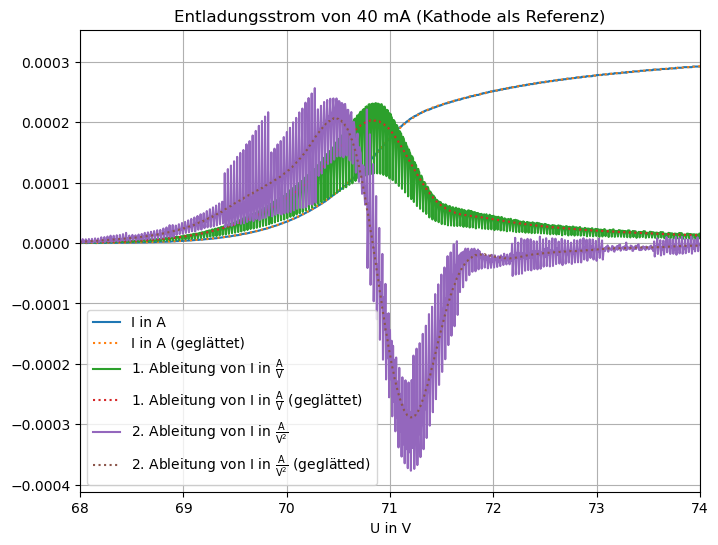

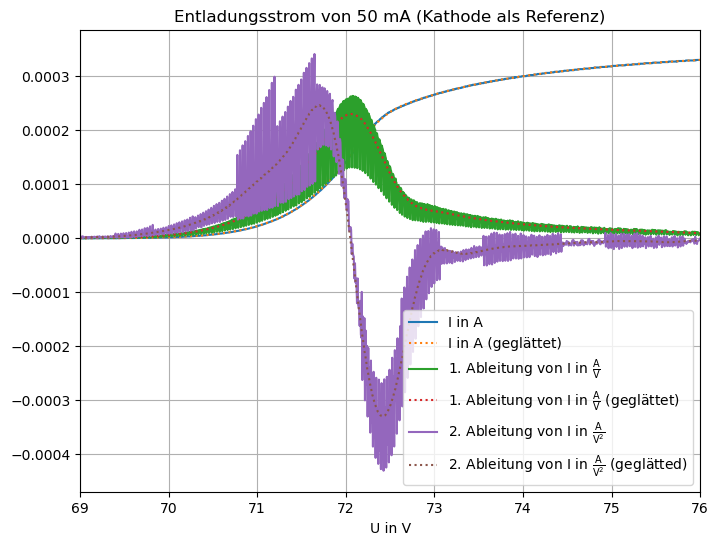

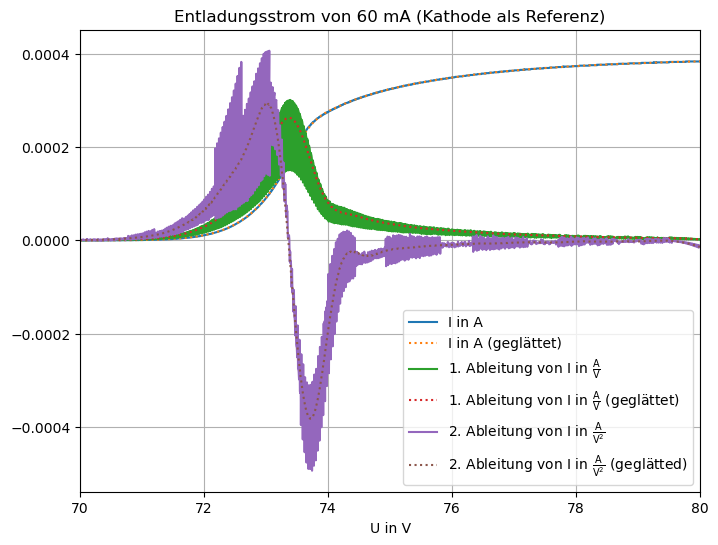

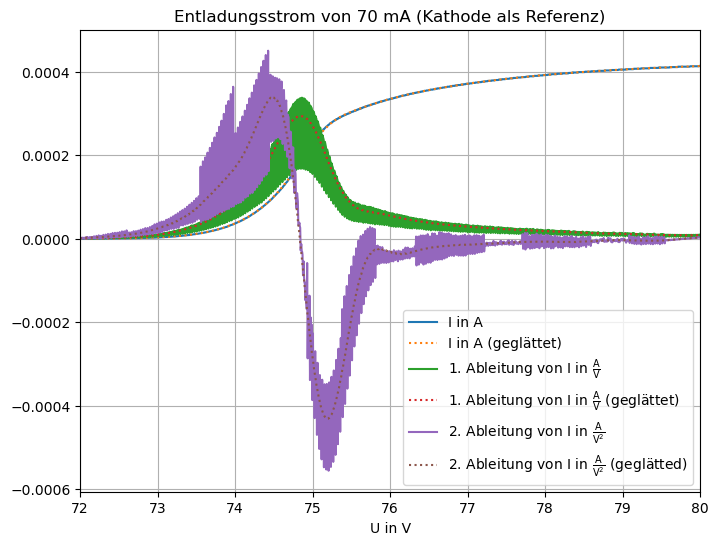

In [328]:
I_30 = plot_deriv(kathode,30,150,150,150,lowerx=68,upperx=74,label_dict='Kathode',filter_polynom_order=3)
plt.savefig('figures/deriv_kathode.pdf')
I_40 = plot_deriv(kathode,40,150,150,150,lowerx=68,upperx=74,label_dict='Kathode')
I_50 = plot_deriv(kathode,50,150,150,150,lowerx=69,upperx=76,label_dict='Kathode')
I_60 = plot_deriv(kathode,60,150,150,150,lowerx=70,upperx=80,label_dict='Kathode')
I_70 = plot_deriv(kathode,70,150,150,150,lowerx=72,upperx=80,label_dict='Kathode')

print(I_30[2][1000:1100])
# Irgendwelche komischen Effekte treten auf, die bei der Anode nicht waren...
# Scheint aber nichts periodisches zu sein, sondern einzelne Werte die stets kleiner sind...


Bestimmung der Potentiale und Sättigungsströme:

Floating Potential:  [68.54391383688979, 68.02862052197415, 69.30956588738826, 70.65212149873344, 72.18528089752635]
Plasma Potential:  [71.22999949999999, 70.7775005, 72.0625, 73.3774985, 74.8424985]
Ionensättigungsstrom:  [-3.103393144111997e-07, -3.378686566207686e-07, -3.8368083230885675e-07, -3.582831657532509e-07, -4.265172052877383e-07]
Fehler Ionensättigungsstrom:  [1.442721010897352e-08, 7.1250477059472355e-09, 7.359766029787651e-09, 1.0037594240810678e-08, 6.319055716280611e-09]
Elektronensättigungsstrom:  [0.0001219767210736491, 0.00013174073800206767, 0.00015522693886660526, 0.00017173196241369442, 0.00018309365935766182]
Fehler Elektronensättigungsstrom:  [1.7311760439309115e-05, 1.901079175472471e-05, 2.1975174410033574e-05, 2.5110426167530527e-05, 2.810572516189245e-05]


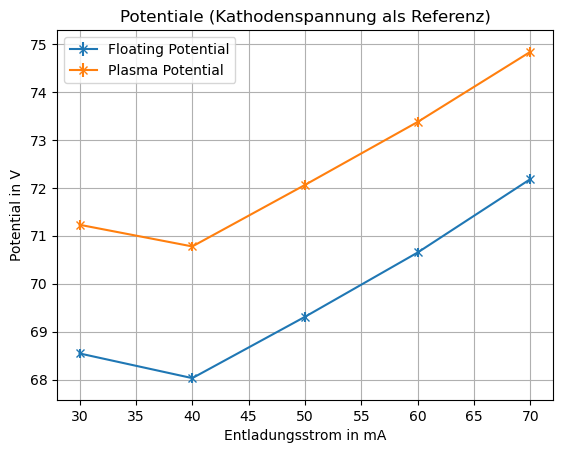

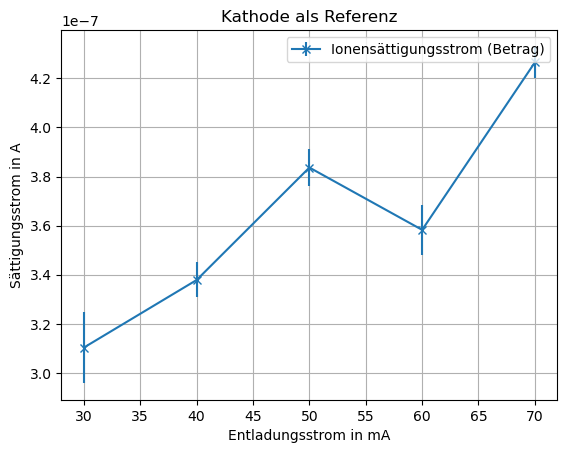

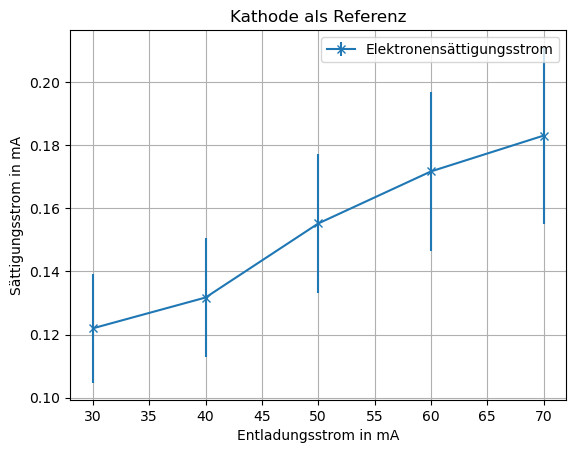

In [329]:
currents = [I_30,I_40,I_50,I_60,I_70]
labels = [30,40,50,60,70]
float_pot = []
plasma_pot = []
float_pot_index = []
plasma_pot_index = []
i_satt = []
i_satt_std = []
e_satt = []
e_satt_err = []
for current in currents:
    float_pot.append(floating_potential(current[0],current[1])[0])
    plasma_pot.append(plasma_potential(current[4],current[3])[0])
    float_pot_index.append(floating_potential(current[0],current[1])[1])
    plasma_pot_index.append(plasma_potential(current[4],current[3])[1])
    ayuda = satt(current[0],current[1],current[4],current[3])
    i_satt.append(ayuda[0])
    e_satt.append(ayuda[1])
    i_satt_std.append(ayuda[2])
    e_satt_err.append(ayuda[3])

ax = plt.subplots()
plt.errorbar(labels,float_pot,yerr=0.1,marker='x',label='Floating Potential')
plt.errorbar(labels,plasma_pot,yerr=0.1,marker='x',label='Plasma Potential')
plt.grid()
plt.legend()
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Potential in V')
plt.title('Potentiale (Kathodenspannung als Referenz)')
plt.savefig('figures/pot_kathode.pdf')

ax = plt.subplots()
plt.errorbar(labels,-1.0*np.array(i_satt),yerr=i_satt_std,marker='x',label='Ionensättigungsstrom (Betrag)')
plt.grid()
plt.legend()
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Sättigungsstrom in A')
plt.title('Kathode als Referenz')
plt.savefig('figures/ion_satt_kathode.pdf')

ax = plt.subplots()
plt.errorbar(labels,np.array(e_satt)*1e3,yerr=np.array(e_satt_err)*1e3,marker='x',label='Elektronensättigungsstrom')
plt.grid()
plt.legend()
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Sättigungsstrom in mA')
plt.title('Kathode als Referenz')
plt.savefig('figures/e_satt_kathode.pdf')

print('Floating Potential: ',float_pot)
print('Plasma Potential: ',plasma_pot)
print('Ionensättigungsstrom: ',i_satt)
print('Fehler Ionensättigungsstrom: ',i_satt_std)
print('Elektronensättigungsstrom: ',e_satt)
print('Fehler Elektronensättigungsstrom: ',e_satt_err)

Bestimmung verschiedener Parameter:

C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1480551374.py:29: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1480551374.py:29: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1480551374.py:29: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1480551374.py:29: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\1480551374.py:29: RuntimeWarning: invalid value encountered in log
  I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])


Elektronentemperatur:  [4624.988625718991, 4836.59353433673, 4809.446261303345, 4636.259730483711, 4602.433523921547]
Fehler Elektronentemperatur:  [12.2899696080807, 11.299570080636704, 7.231865112811367, 6.744662193527759, 4.912181736456955]
Elektronendichte:  [783458848171770.5, 827455917406020.8, 977719156569939.9, 1101696128765394.2, 1178892248321173.0]
Fehler Elektronendichte:  [188877428419675.34, 201319031111010.22, 234795317748789.25, 269664562812114.5, 296920955081529.4]
Ionendichte:  [357652871145984.44, 380766176930591.3, 433613524238667.1, 412403913595684.8, 492745930947884.4]
Fehler Ionendichte:  [18836229343376.844, 29663970769407.33, 34427147216650.24, 29090005224790.84, 41166094533870.45]
Elektronen-Debye-Länge:  [0.00016766903012779388, 0.0001668410732827778, 0.00015305449493193776, 0.00014156587570502804, 0.00013635225311836057]
Fehler Elektronen-Debye-Länge:  [2.0433723240829092e-05, 2.0491008976577637e-05, 1.849278271342457e-05, 1.7428666430219843e-05, 1.7243901706

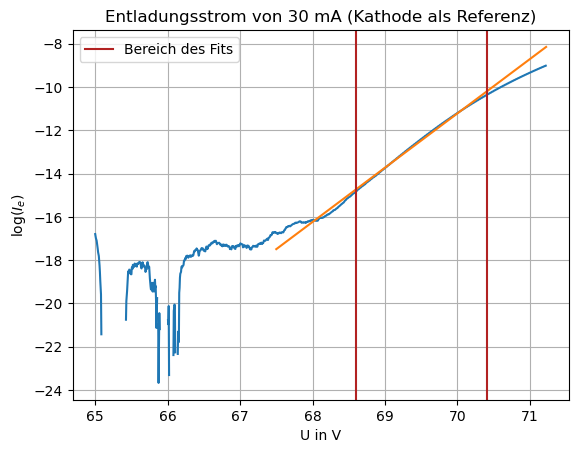

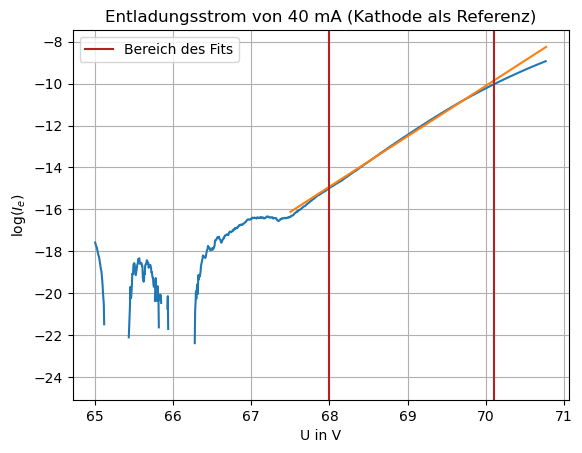

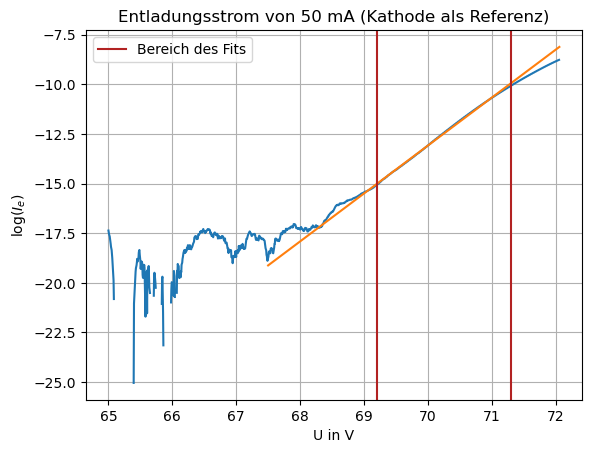

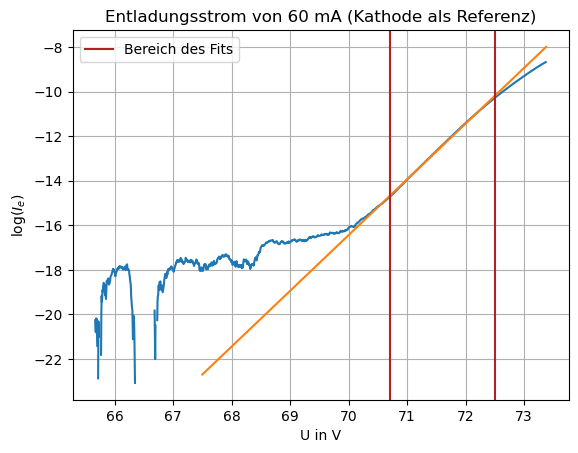

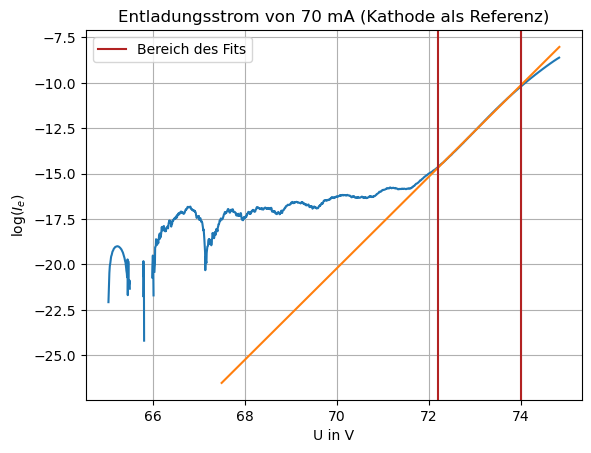

In [330]:
currents = [I_30,I_40,I_50,I_60,I_70]
labels = [30,40,50,60,70]
fit_lim = [(600,900),(500,850),(700,1050),(950,1250),(1200,1500)]  # Grenzen für die einzelnen Fits
def lin_func(m,b,x):
    return m*x+b

T_el = []
n_el = []
n_ion = []
debye_e = []
debye_i = []
parameter_e = []
parameter_i = []
T_el_err = []
n_el_err = []
n_ion_err = []
debye_e_err = []
debye_i_err = []
parameter_e_err = []
parameter_i_err = []

A = 9.2e-6  # Sondenfläche
A_err = 0.9e-6  # Fehler Sondenfläche
m_i = 6.6335e-26  # Masse Argon in kg

for i,current in enumerate(currents):
    '''Betrachte bis zum Plasmapotential.'''
    U = current[1][:plasma_pot_index[i]]
    I = np.log(current[0][:plasma_pot_index[i]]-i_satt[i])
    ax = plt.subplots()
    plt.plot(U,I)
    plt.xlabel('U in V')
    plt.ylabel('$\log(I_e)$')
    plt.grid()
    plt.title('Entladungsstrom von '+str(labels[i])+' mA (Kathode als Referenz)')
    
    m, b, r, p, se = linregress(U[fit_lim[i][0]:fit_lim[i][1]],I[fit_lim[i][0]:fit_lim[i][1]])
    lin = np.linspace(67.5,current[1][plasma_pot_index[i]],1000)
    plt.plot(lin,lin_func(m,b,lin))
    plt.axvline(U[fit_lim[i][0]],color='firebrick')
    plt.axvline(U[fit_lim[i][1]],color='firebrick',label='Bereich des Fits')

    plt.legend()
    plt.savefig('figures/bestimmung_T_'+str(labels[i])+'kathode.pdf')

    T_el.append(slope_to_T(m))
    T_el_err.append(T_err(m,se))
    n_el.append(n_e(e_satt[i],A,T_el[-1]))
    n_el_err.append(n_e_err(e_satt[i],e_satt_err[i],A,A_err,T_el[-1],T_el_err[-1]))
    n_ion.append(n_i(i_satt[i],A,T_el[-1],m_i))
    n_ion_err.append(n_i_err(i_satt[i],i_satt_std[i],A,A_err,T_el[-1],T_el_err[-1],m_i))    
    debye_e.append(debye(T_el[-1],n_el[-1]))
    debye_e_err.append(debye_err(T_el[-1],T_el_err[-1],n_el[-1],n_el_err[-1]))
    #debye_i.append(debye(T_el[-1],n_ion[-1]))
    #debye_i_err.append(debye_err(T_el[-1],T_el_err[-1],n_ion[-1],n_ion_err[-1]))
    debye_i.append(debye(T_ion,n_ion[-1]))
    debye_i_err.append(debye_err(T_ion,T_ion_err,n_ion[-1],n_ion_err[-1]))
    parameter_e.append(plasma_parameter(debye_e[-1],n_el[-1]))
    parameter_e_err.append(plasma_parameter_err(debye_e[-1],debye_e_err[-1],n_el[-1],n_el_err[-1]))
    parameter_i.append(plasma_parameter(debye_i[-1],n_ion[-1]))
    parameter_i_err.append(plasma_parameter_err(debye_i[-1],debye_i_err[-1],n_ion[-1],n_ion_err[-1]))

print('Elektronentemperatur: ',T_el)
print('Fehler Elektronentemperatur: ',T_el_err)
print('Elektronendichte: ',n_el)
print('Fehler Elektronendichte: ',n_el_err)
print('Ionendichte: ',n_ion)
print('Fehler Ionendichte: ',n_ion_err)
print('Elektronen-Debye-Länge: ',debye_e)
print('Fehler Elektronen-Debye-Länge: ',debye_e_err)
print('Ionen-Debye-Länge: ',debye_i)
print('Fehler Ionen-Debye-Länge: ',debye_i_err)
print('Elektronen-Plasmaparameter: ',parameter_e)
print('Fehler Elektronen-Plasmaparameter: ',parameter_e_err)
print('Ionen-Plasmaparameter: ',parameter_i)
print('Fehler Ionen-Plasmaparameter: ',parameter_i_err)

Plots der Parameter:

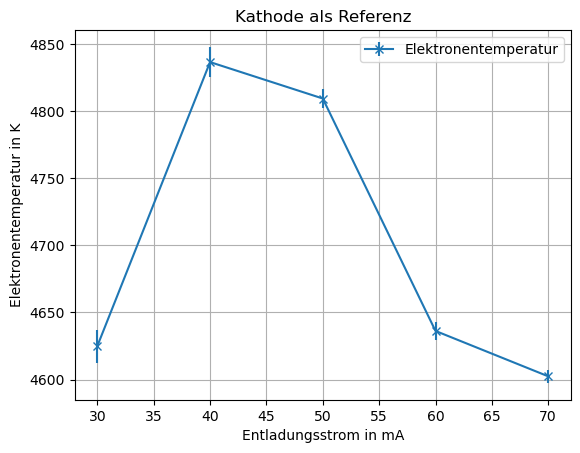

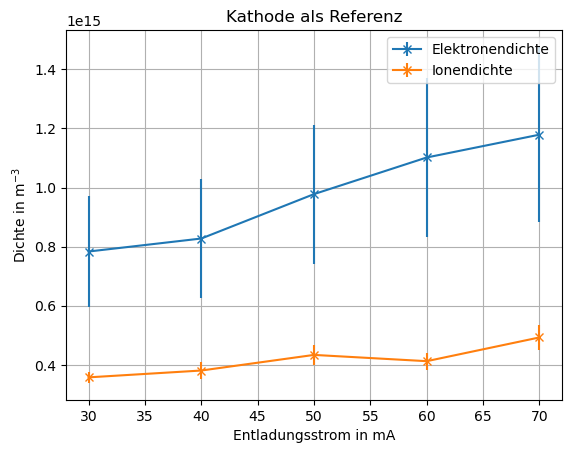

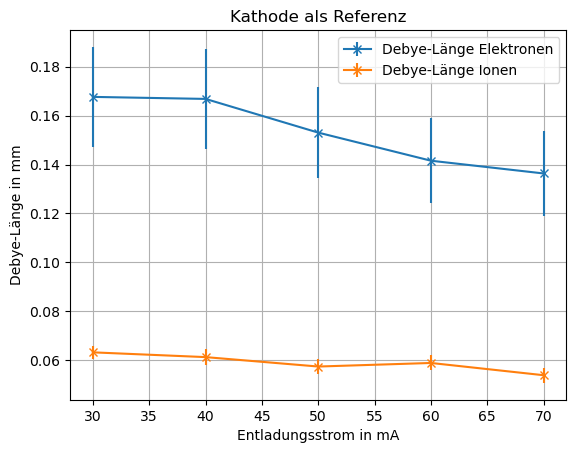

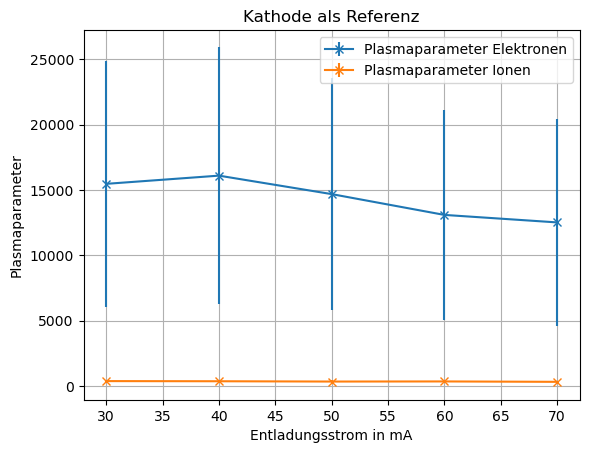

In [331]:
labels = [30,40,50,60,70]

ax = plt.subplots()
plt.errorbar(labels,T_el,yerr=T_el_err,marker='x',label='Elektronentemperatur')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Elektronentemperatur in K')
plt.title('Kathode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/Te_kathode.pdf')

ax = plt.subplots()
plt.errorbar(labels,n_el,yerr=n_el_err,marker='x',label='Elektronendichte')
plt.errorbar(labels,n_ion,yerr=n_ion_err,marker='x',label='Ionendichte')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Dichte in m$^{-3}$')
plt.title('Kathode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/n_kathode.pdf')

ax = plt.subplots()
plt.errorbar(labels,np.array(debye_e)*1e3,yerr=np.array(debye_e_err)*1e3,marker='x',label='Debye-Länge Elektronen')
plt.errorbar(labels,np.array(debye_i)*1e3,yerr=np.array(debye_i_err)*1e3,marker='x',label='Debye-Länge Ionen')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Debye-Länge in mm')
plt.title('Kathode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/debye_kathode.pdf')

ax = plt.subplots()
plt.errorbar(labels,parameter_e,yerr=parameter_e_err,marker='x',label='Plasmaparameter Elektronen')
plt.errorbar(labels,parameter_i,yerr=parameter_i_err,marker='x',label='Plasmaparameter Ionen')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Plasmaparameter')
plt.title('Kathode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/eta_kathode.pdf')

Druyvestein-Methode:

C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)


Druyvestein:  -699481803970912.5
Maxwell:  -757031000198288.2
Druyvestein:  -744943772043291.0
Maxwell:  -822385186741545.8


C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)


Druyvestein:  -876273772057600.1
Maxwell:  -987046594026318.0


C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)
C:\Users\ebel1\AppData\Local\Temp\ipykernel_4792\3198558347.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*const.e*U_p/const.m_e)


Druyvestein:  -980759239883083.5
Maxwell:  -1115647590156090.6
Druyvestein:  -1064856692046597.0
Maxwell:  -1208237100750788.0
[757461386826626.6, 822878331105398.9, 987215097424188.9, 1115789693210288.5, 1208396335135510.8]
[5132079424359.4375, 4564892089360.333, 5539890145881.124, 5496487715110.646, 5384405750696.179]


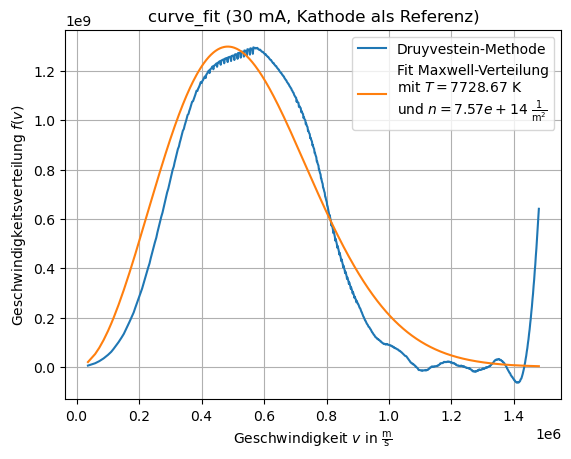

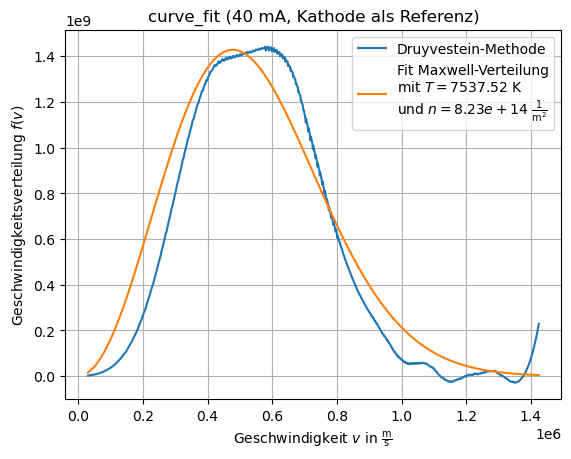

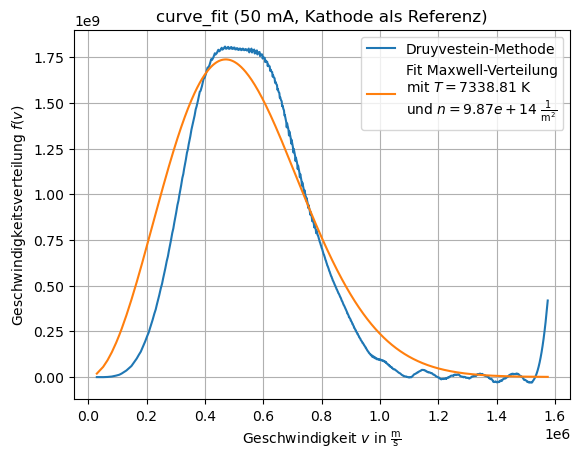

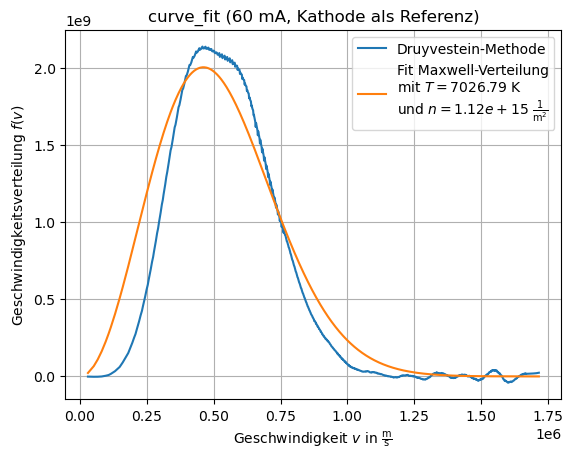

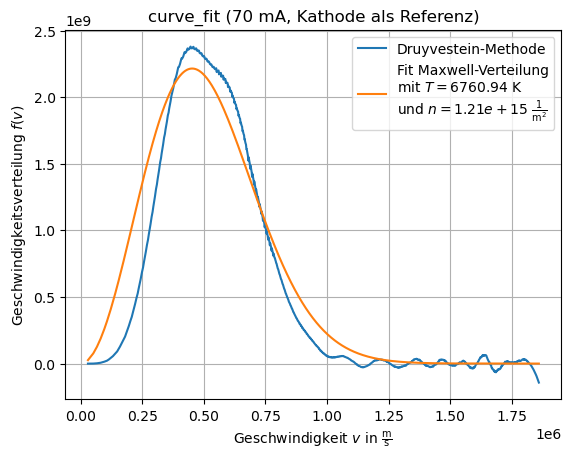

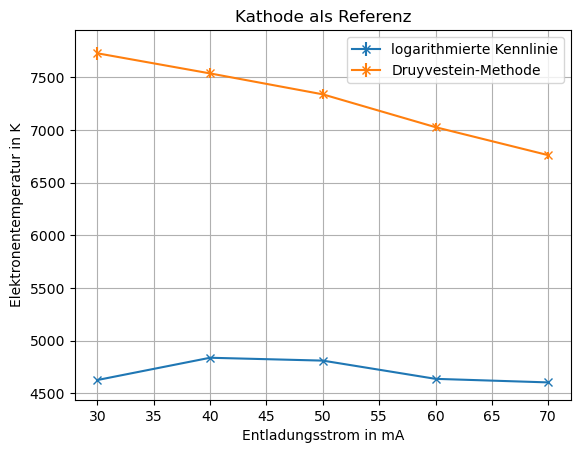

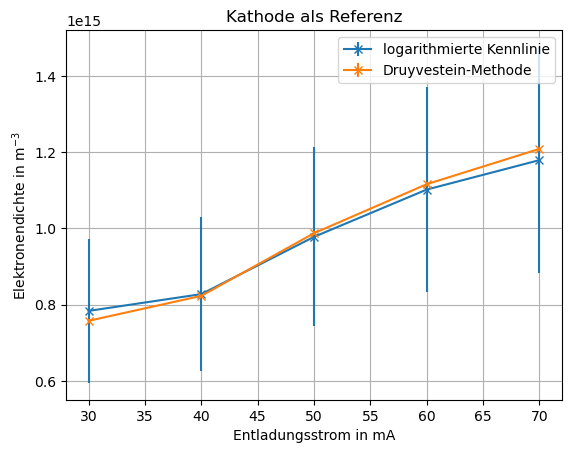

In [332]:
currents = [I_30,I_40,I_50,I_60,I_70]
labels = [30,40,50,60,70]
hand_fit = [4900,4000,4800,4800,4800]
T_list = []
T_error_list = []
n_list = []
n_error_list = []

for i, current in enumerate(currents):
    I_1 = current[4]
    U_1 = current[3]
    I_2 = current[7]
    U_2 = current[6]
    phi_p = plasma_pot[i]
    # print(phi_p)

    # Berechnung der Geschwindigkeitsverteilung
    U_p = phi_p - U_2
    v = U_p_to_v(U_p)
    f = druyvestein_2(9.2e-6,I_2,v)

    # Normierung Druyvestein (nan-Werte müssen entfernt werden; Druyvestein muss umgedreht werden, da v falsch herum ist)
    # Fitte Temperatur über scipy.optimize.curve_fit mit p0 als inital guess
    mask = np.isfinite(v) & np.isfinite(f)
    f = f[mask]
    # f_norm = -1.0*f[mask]/np.trapz(f[mask],v[mask])
    v = v[mask]

    # popt, pconv = curve_fit(maxwell,v,f_norm,p0=4800)
    # T = popt[0]
    # T_std = np.sqrt(np.diag(pconv)[0])    # Standardabweichung der Temperatur
    # T_list.append(T)
    # T_error_list.append(T_std)

    # maxwell1 = maxwell(v,T)
    # maxwell2 = maxwell(v,hand_fit[i])

    popt, pconv = curve_fit(maxwell_2,v,f,p0=(7500,1.0e15))
    T = popt[0]
    T_std = np.sqrt(np.diag(pconv)[0])    # Standardabweichung der Temperatur
    T_list.append(T)
    T_error_list.append(T_std)
    n = popt[1]
    n_std = np.sqrt(np.diag(pconv)[1])
    n_list.append(n)
    n_error_list.append(n_std)

    maxwell1 = maxwell_2(v,T,n)

    print('Druyvestein: ',np.trapz(f,v))
    print('Maxwell: ',np.trapz(maxwell1,v))

    ax = plt.subplots()
    # plt.plot(v,f_norm,label='Druyvestein-Methode')
    plt.plot(v,f,label='Druyvestein-Methode')
    plt.plot(v,maxwell1,label='Fit Maxwell-Verteilung\nmit $T='+str(round(T,2))+'$ K\nund '+r'$n=%.3g$ $\frac{1}{\mathrm{m}^2}$' % n)
    plt.grid()
    plt.title('curve_fit ('+str(labels[i])+' mA, Kathode als Referenz)')
    plt.xlabel(r'Geschwindigkeit $v$ in $\frac{\mathrm{m}}{\mathrm{s}}$')
    plt.ylabel('Geschwindigkeitsverteilung $f(v)$')
    plt.legend()
    plt.savefig('figures/druyvestein_fit_+'+str(labels[i])+'_kathode.pdf')

    # ax = plt.subplots()
    # plt.plot(v,f_norm,label='Druyvestein-Methode')
    # plt.plot(v,maxwell2,label='Fit Maxwell-Verteilung\nmit $T='+str(hand_fit[i])+'$ K')
    # plt.grid()
    # plt.title('händischer Fit ('+str(labels[i])+' mA, Anode als Referenz)')
    # plt.xlabel(r'Geschwindigkeit $v$ in $\frac{\mathrm{m}}{\mathrm{s}}$')
    # plt.ylabel('normierte Wahrscheinlichkeitsdichte')
    # plt.legend()
    # plt.savefig('figures/druyvestein_hand_+'+str(labels[i])+'_anode.pdf')

ax = plt.subplots()
plt.errorbar(labels,T_el,yerr=T_el_err,marker='x',label='logarithmierte Kennlinie')
plt.errorbar(labels,T_list,yerr=T_error_list,marker='x',label='Druyvestein-Methode')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Elektronentemperatur in K')
plt.title('Kathode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/comparison_T_kathode.pdf')

print(n_list)
print(n_error_list)

ax = plt.subplots()
plt.errorbar(labels,n_el,yerr=n_el_err,marker='x',label='logarithmierte Kennlinie')
plt.errorbar(labels,n_list,yerr=n_error_list,marker='x',label='Druyvestein-Methode')
plt.xlabel('Entladungsstrom in mA')
plt.ylabel('Elektronendichte in m$^{-3}$')
plt.title('Kathode als Referenz')
plt.grid()
plt.legend()
plt.savefig('figures/comparison_n_kathode.pdf')
